# Example 3 - Modeling the Tsanfleuron 3D network 

This is the third notebook in a series aiming at introducing pyKasso.

In this notebook we show how to create a 3D network in a more complex situation. We will use the case study of the Tsanfleuron aquifer in Switzerland. The site has been investigated in detail and a 3D model is available. The detailed information are given in the paper cited below.

To run this notebook, you must first install the pyKasso package on your machine. The code and instructions are  available on the [github page](https://github.com/randlab/pykasso).

**Reference**: Miville, F., Renard, P., Fandel, C., Filipponi, M. 2025: pyKasso: An open-source three-dimensional discrete karst network generator. Environmental Modelling & Software, Volume 186, https://doi.org/10.1016/j.envsoft.2025.106362

© 2025 *François Miville, Chloé Fandel and Philippe Renard - University of Neuchâtel / Carleton College*

## 1. Initialization

As compared to the previous examples, the initialization step is similar, we just use the actual coordinates of the system and store some basic information to facilitate the next steps.

In [1]:
# Import the pyKasso package
import pykasso as pk
import numpy as np
import matplotlib.pyplot as plt
import os 

# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0': 2582750, 'y0': 1127767, 'z0': 1000,
    'nx': 394, 'ny': 193, 'nz': 100,
    'dx': 20, 'dy': 20, 'dz': 20
}

# Defines the name of the project
project_name = 'example_03'

# Declare the project parameters
app.new_project(name=project_name, grid_parameters=grid_parameters)

# Retrieves information from the project
nx, ny, nz = app.model.grid.shape
app.visualizer.notebook = True
dr = pk.create_datareader(grid=app.project.grid)

extent = app.project.grid.extent

# Defines graphical parameters
font_size = 12
cpos = [1,-1.2,1.1]
window_size = (500, 350)
zoom = 1.3

## 2. Prepare the input data

We then need to import progressively all the input data by reading the input files into the notebook and visualizing them to check that they are correct.

### 2a. Unziping the data

The input data files for the site are stored in the compressed archive `tsanfleuron_data.zip`. Before setting the model parameters, we need to unzip the archive and move all its content in the `inputs` directory of the project.

In [2]:
from zipfile import ZipFile

# for compatibility windows/linux
input_dir = os.path.join(project_name, 'inputs') 

zipfilename = 'tsanfleuron_data.zip'
with ZipFile(zipfilename,'r') as myzip:
    myzip.extractall(input_dir)

### 2b. Topography

We start with the digital elevation model and plot it.

The digital elevation model is stored in the numpy array topography.


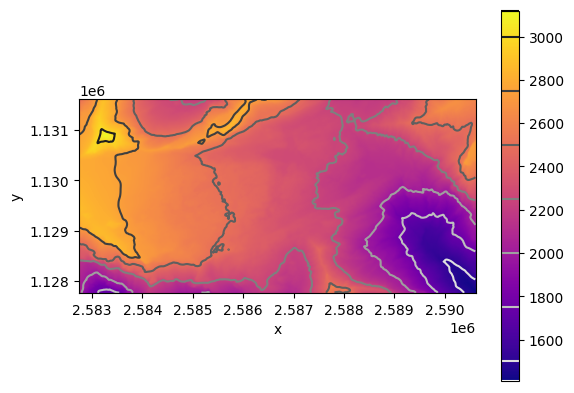

In [3]:
# Load
filename = os.path.join(input_dir, 'elevation_model.tif')
topography = dr.get_data_from_file(filename)

# Plot
imshow_options = {
    'extent' : extent,
    'cmap' : 'plasma'
}
contour_options = {
    'cmap' : 'binary'
}
fig = app.visualizer.mpl_plot_array_2D(
    topography,
    imshow_options=imshow_options,
    contour_options=contour_options,
    show_colorbar=True,
)

### 2c. 3D geologic model

We now import a 3D voxell describing the geological model. It is a regular grid. In each cell of the grid a code indicates the geological formation. To facilitate the interpretation of these values, a dictionary is used to associate the code and the name of the geological formation.

We then provide the costs for the fast marching algorithm for the formations that will be karstifiable.

In the `geology_model` dictionnary, we indicate that the generation of the karst network must be done only in the formations 8 and 9 corresponding to the Urgonian and Eocene formations. All the other formations will not be taken into account.

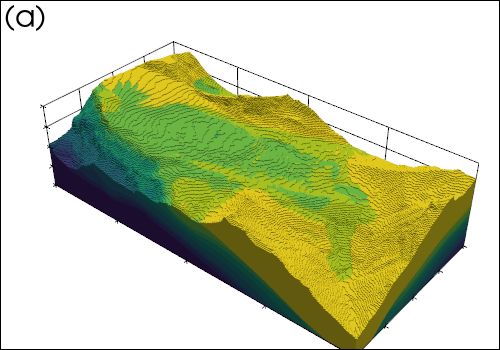

In [4]:
# Load geologic model
filename = os.path.join(input_dir, 'tsanfleuron_geology.vox')
df = dr.get_dataframe_from_file(filename)
geology = dr._get_data_from_vox_df(df)

# Set names
geology_names = {
    -9999: 'Out',
    0: None,
    1: 'UHNappe',
    2: 'Dogger',
    3: 'Malm',
    4: 'Berriasian',
    5: 'LateBerriasianValanginian',
    6: 'Hauterivian',
    7: 'EarlyBarremian',
    8: 'Urgonian',
    9: 'Eocene',
    10: 'Wildhorn',
}

# Set costs
geology_costs = {
    8: 0.4,
    9: 0.4,
}

# Set model
geology_model = {
    -9999: False,
    0: False,
    1: False,
    2: False,
    3: False,
    4: False,
    5: False,
    6: False,
    7: False,
    8: True,
    9: True,
    10: False,
}

# Plot
settings = {
    'text_options' : {
        'text': '(a)',
        'font_size': font_size,
    },
    'mask_values': [-9999],
    'show_scalar_bar': False,
}
fig = app.visualizer.pv_plot_array(
    geology,
    settings=settings,
    cpos=cpos,
    window_size=window_size,
    zoom=zoom,
    savefig=True,
    filename=os.path.join('fig','example_03_geologic_model'),
)

### 2d. Faults model

The major faults have been mapped in the region and modelled in 3D using a deterministic approach. In the code block below, we will import these faults following the same strategy that was used for the geological model. 


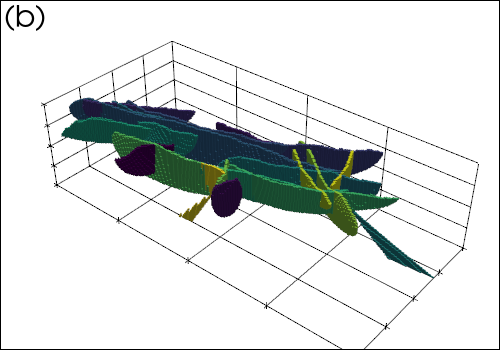

In [5]:
# Load faults model
filename = os.path.join(input_dir, 'tsanfleuron_faults.vox')
df = dr.get_dataframe_from_file(filename)
faults = dr._get_data_from_vox_df(df)

# Set names
faults_ids = list(range(21))
faults_names_ = ['Chevauchement', 'NEESOO1', 'NEESOO2', 'NESO1', 'NESO11',
                 'NESO2', 'NESO22', 'NESO3', 'NESO32', 'NESO4', 'NESO42',
                 'NESO43', 'NESO44', 'NESO5', 'NESO6', 'NESO7', 'NOOSEE1',
                 'NOOSEE2', 'NOOSEE3', 'NS2', 'OE1']
faults_names = {faults_id: faults_name for (faults_id, faults_name) in zip(faults_ids, faults_names_)}

# Plot
settings = {
    'text_options' : {
        'text': '(b)',
        'font_size': font_size,
    },
    'mask_values': [0],
    'show_scalar_bar': False,
}
fig = app.visualizer.pv_plot_array(
    faults,
    settings=settings,
    cpos=cpos,
    window_size=window_size,
    zoom=zoom,
    savefig=True,
    filename=os.path.join('fig','example_03_faults_model'),
)

### 2e. Position of the outlet

The location of the outlet is known. We only provide its coordinate and plot it to check that there is no error.

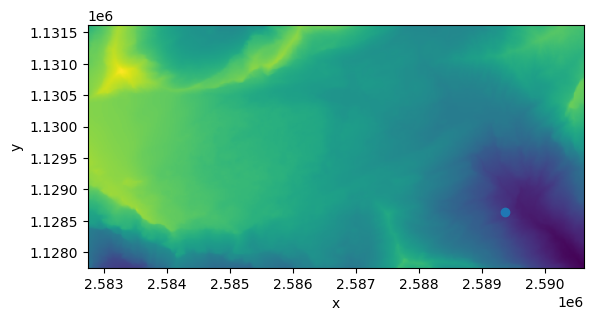

In [6]:
outlet = [2589373., 1128641.]

# Plot
x, y = outlet
app.visualizer.mpl_plot_array_2D(topography, imshow_options={'extent':extent})
plt.scatter(x,y)

### 2f. Water table

For the boundary between the vadose and phreative zone, we assume that the water level is equal to the altitude of the outlet. This is a strong asumption, but it is sufficient here to demonstrate how to use pykasso. 

The code below extracts the altitude from the digital elevation model at the location of the outlet. It then creates a numpy array of constant value.

In [7]:
i, j = app.model.grid.get_indices(outlet)
level = topography[i, j]
water_table = np.full((nx, ny), level)
level

array([1686.1437], dtype=float32)

## 3. Setting the model parameters

To set the model parameters, we must fill the parameters dictionnary of pykasso. The `sks` algorithm is set to `Riemann3` to use the anisotropic fast marching. Most of the parameters are set to the input values that we defined in the previous part of this notebook.

For the fractures, we consider 4 fracture sets with different statistical distributions. Their parameters are directly set within the model parameters dictionnary.

In [8]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'seed' : 3333,
        'algorithm': 'Riemann3',
        'costs': {'ratio': 0.1}
    },
    'domain' : {
        'water_table' : water_table,
    },
    'outlets' : {
        'data' : [outlet],
        'number' : 1,
        'subdomain' : 'domain_surface', 
    },
    'inlets' : {
        'data' : 'tsanfleuron_inlets.txt',
        'number': 22,
        'importance': [1, 1, 2],
    },
    'geology' : {
        'data' : geology,
        'names' : geology_names,
        'costs' : geology_costs,
        'model' : geology_model,
    },
    'faults' : {
        'data' : faults,
        'names' : faults_names,
    },
    'fractures' : {
        'generate': {
            'family_01': {
                'density'      : 4.5e-4,
                'orientation'  : [32, 86],
                'dip'          : 90,
                'length'       : [20, 400],
                'alpha'        : 1.4,
            },
            'family_02': {
                'density'      : 1.2e-4,
                'orientation'  : [146, 196],
                'dip'          : 90,
                'length'       : [20, 130],
                'alpha'        : 1.2,
            },
            'family_03': {
                'density'      : 4.5e-4,
                'orientation'  : [98, 163],
                'dip'          : 90,
                'length'       : [20, 740],
                'alpha'        : 2.1,
            },
            'family_04': {
                'density'      : 2.8e-4,
                'orientation'  : [72, 115],
                'dip'          : 90,
                'length'       : [20, 160],
                'alpha'        : 1.8,
            }
        }
    }
}

## 4. Generating the karst network simulations

The network generation is now more complex. It takes a pair of minutes per simulation. It is therefore a good practice to launch only the generation of one network to start. This allows visualizing the results checking that the parameters are ok and the code is functionning correctly. If this is fine, then multiple realizations can be generated in a second step by changing the number of iterations in the loop below.

In [9]:
# Compute 1 simulation
for i in range(1):
    model_parameters['sks']['seed'] = i
    app.model.generate(model_parameters=model_parameters)

## 5. Checking the parameters and results

The code blocks below shows how to view the tables containing the model parameters to check if they have been set properly. 


### 5a. Parameter values

In [10]:
app.model.conceptual_model_table

,feature,data_id,name,cost
model_id,,,,
0,Out,NaN,NaN,10.0
100,Geology,8.0,Urgonian,0.4
101,Geology,9.0,Eocene,0.4
200,Fractures,1.0,family_01,0.2
201,Fractures,2.0,family_02,0.2
202,Fractures,3.0,family_03,0.2
203,Fractures,4.0,family_04,0.2
300,Faults,1.0,NEESOO1,0.2
301,Faults,2.0,NEESOO2,0.2


In [11]:
app.model.geology.overview()

,names,costs,model,counts,freq,volume
-9999,Out,0.4,False,2417768,0.317952,19342144000
0,None,0.4,False,76042,0.010000,608336000
1,UHNappe,0.4,False,1176888,0.154768,9415104000
2,Dogger,0.4,False,332223,0.043689,2657784000
3,Malm,0.4,False,404256,0.053162,3234048000
4,Berriasian,0.4,False,734488,0.096590,5875904000
5,LateBerriasianValanginian,0.4,False,561294,0.073814,4490352000
6,Hauterivian,0.4,False,472503,0.062137,3780024000
7,EarlyBarremian,0.4,False,300860,0.039565,2406880000
8,Urgonian,0.4,True,520876,0.068498,4167008000


In [12]:
app.model.faults.overview()

,names,costs,model,counts,freq,volume
0,Chevauchement,0.2,False,7519504,0.988862,60156032000
1,NEESOO1,0.2,True,1872,0.000246,14976000
2,NEESOO2,0.2,True,1511,0.000199,12088000
3,NESO1,0.2,True,1961,0.000258,15688000
4,NESO11,0.2,True,3592,0.000472,28736000
5,NESO2,0.2,True,4554,0.000599,36432000
6,NESO22,0.2,True,9143,0.001202,73144000
7,NESO3,0.2,True,14130,0.001858,113040000
8,NESO32,0.2,True,2139,0.000281,17112000
9,NESO4,0.2,True,1422,0.000187,11376000


In [13]:
app.model.fractures.overview()

,names,costs,model,counts,freq,volume
0,family 0,0.2,False,7016486,0.922712,56131888000
1,family_01,0.2,True,306314,0.040282,2450512000
2,family_02,0.2,True,24726,0.003252,197808000
3,family_03,0.2,True,202627,0.026647,1621016000
4,family_04,0.2,True,54047,0.007108,432376000


### 5b. Discrete fracture network (DFN)

Before running the simulation, we checked all the inputs. But we did not verify the stochastic fracture network, because it was not generated yet. We only gave the statistical parameters in the parameter dictionnary.

If one wants to check the results of the DFN simulation, it has to be done after the simulation. Below, we first plot the simulated DFN. 

We then compute and plot some basic statistics on the generated fractures to be able to check the simulation. 

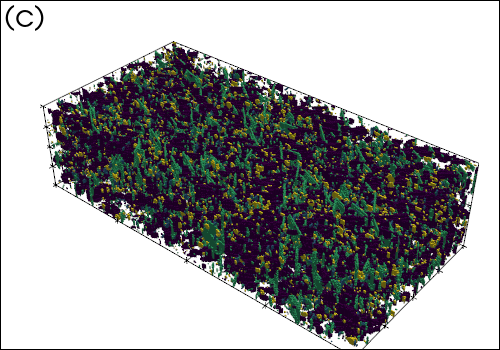

In [14]:
# Plot fracturation
settings = {
    'text_options' : {
        'text': '(c)',
        'font_size': font_size,
    },
    'mask_values': [0],
    'show_scalar_bar': False,
}
fig = app.visualizer.pv_plot_array(
    app.model.fractures.data_volume,
    settings=settings,
    cpos=cpos,
    window_size=window_size,
    zoom=zoom,
    savefig=True,
    filename=os.path.join('fig','example_03_fracturation_model')
)

In [15]:
fractures = app.model.fractures.fractures
families = app.model.fractures.families

hist_settings = {
    'by' : 'family_id',
    'bins' : 10,
    'layout' : (2,2),
    'density' : True
}

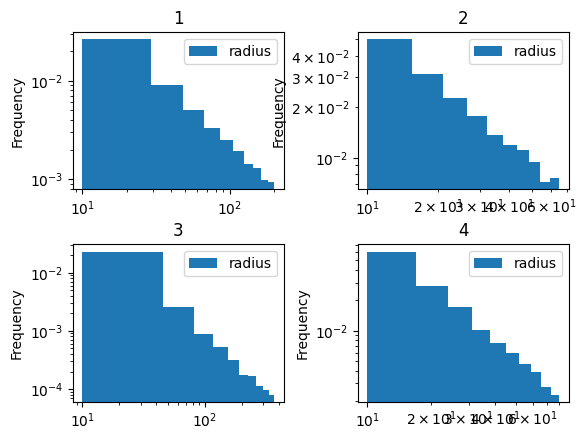

In [16]:
# Distribution of radius
axes = fractures.plot.hist(column='radius', logy=True, logx=True, **hist_settings)
plt.subplots_adjust(hspace=0.35, wspace=0.35)


array([[<Axes: title={'center': '1'}, ylabel='Frequency'>,
        <Axes: title={'center': '2'}, ylabel='Frequency'>],
       [<Axes: title={'center': '3'}, ylabel='Frequency'>,
        <Axes: title={'center': '4'}, ylabel='Frequency'>]], dtype=object)

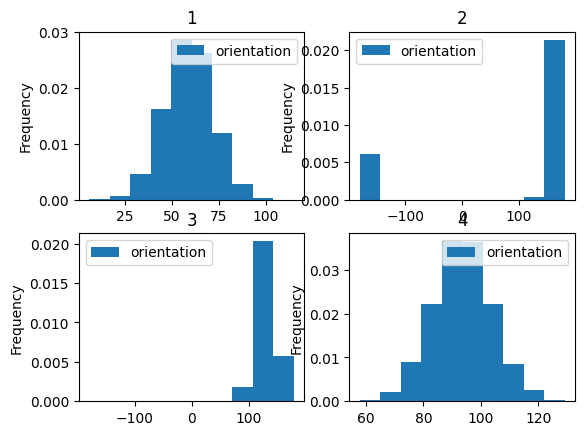

In [17]:
# Orientation
fractures.plot.hist(column='orientation', **hist_settings)

array([[<Axes: title={'center': '1'}, ylabel='Frequency'>,
        <Axes: title={'center': '2'}, ylabel='Frequency'>],
       [<Axes: title={'center': '3'}, ylabel='Frequency'>,
        <Axes: title={'center': '4'}, ylabel='Frequency'>]], dtype=object)

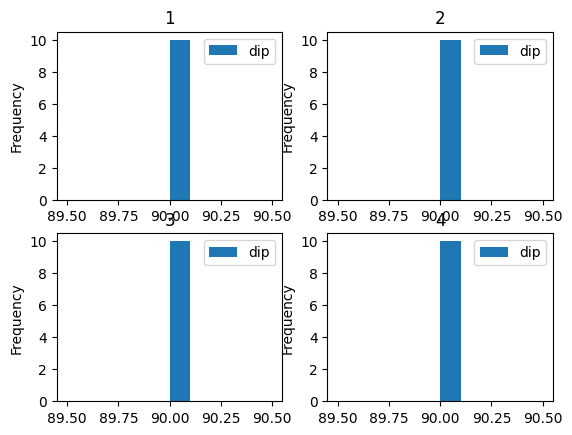

In [18]:
# Dip
fractures.plot.hist(column='dip', **hist_settings)

## 6. Evaluating the plausibility

To check if the simulates network is plausible, one can compute the statistical metrics that have been defined by Collon et al. (2017) to characterize a karst network.

By comparing the value of the statistics with the values computed on real networks, one can evaluate the plausibility of a simulation. If the values computed on the simulated networks are within the range of the statistics observed on real networks, the statistics is displayed in green. The network is plausible. If the value is out of the range observed on real networks the statistic is displayed in orange and this may indicate that a specific simulation is not very plaussible.

For the simulations in Tsanfleuron, most of the statistics are acceptable. Some networks have an average shortest path length (aspl) that is slightly too high. And most networks do not have a plausible coefficient of variation of the vertex degree. This is an indication that the model should be improved, but still the simulations are globally reasonable.

**Reference**: Collon, P., Bernasconi D., Vuilleumier C., and Renard P., 2017, Statistical metrics for the characterization of karst network geometry and topology. Geomorphology. 283: 122-142 doi:10.1016/j.geomorph.2017.01.034 http://dx.doi.org/doi:10.1016/j.geomorph.2017.01.034

In [19]:
df = app.analyzer.compute_metrics()
app.analyzer.compare_metrics(df)

,mean length,cv length,length entropy,tortuosity,orientation entropy,aspl,cpd,mean degree,cv degree,correlation vertex degree
0,94.822487,2.589970,0.145614,1.164746,0.924970,58.228006,0.337421,2.578313,0.294595,-0.377293


## 7. 3D plot

Finally, we use pyvista to plot in 3D the resulting network.

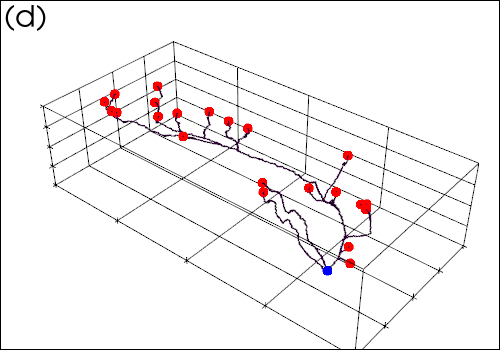

In [20]:
app.visualizer.notebook = True
last_sims = app.project.get_last_simulations(1)
settings = {
    'text_options' : {
        'text': '(d)',
        'font_size': font_size,
    },
    'surfaces_options' : {
        # 'water_table' : {}
    },
    'show_outline' : True,
    'show_scalar_bar' : False,
    'mask_values': [0],
    'inlets_options' : {'point_size': 10},
    'outlets_options' : {'point_size': 10},
    
}
app.visualizer.pv_show(
    simulations=last_sims,
    features=['karst'],
    settings=settings,
    cpos=cpos,
    window_size=window_size,
    zoom=zoom,
    savefig=True,
    filename=os.path.join('fig','example_03_karst_model')
)

In [21]:
plotter = app.visualizer.pv_show(
    simulations=[-1],
    features=['karst'],
    settings=settings,
    cpos=[1, -1, 1],
    return_plotter=True,
)
plotter.export_html('example_03.html')